### Imports

In [145]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno

### Read data from git repo

Reaeding in the pre-mapped data

In [146]:
# Read in dataset & fill "?" values with na
df = pd.read_csv("https://raw.githubusercontent.com/JosephLazarus/QTW/main/Case%20Study%202/Data/mapped_diabetes.csv", na_values='?')
df.head()

c:\Users\OaklandHillsMansion\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,was_readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,Trauma Center,Unknown/Invalid,Physician Referral,1,...,No,No,No,No,No,No,No,No,NO,0
1,149190,55629189,Caucasian,Female,[10-20),NaN,Urgent,Discharged/transferred to another short term h...,Emergency Room,3,...,Up,No,No,No,No,No,Ch,Yes,>30,0
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,Urgent,Discharged/transferred to another short term h...,Emergency Room,2,...,No,No,No,No,No,No,No,Yes,NO,0
3,500364,82442376,Caucasian,Male,[30-40),NaN,Urgent,Discharged/transferred to another short term h...,Emergency Room,2,...,Up,No,No,No,No,No,Ch,Yes,NO,0
4,16680,42519267,Caucasian,Male,[40-50),NaN,Urgent,Discharged/transferred to another short term h...,Emergency Room,1,...,Steady,No,No,No,No,No,Ch,Yes,NO,0


### df shape

Check dataframe shape

In [147]:
df.shape

(101766, 51)

### Check class imbalance

In [148]:
df_gb = df.groupby("was_readmitted")["readmitted"].count().reset_index(name="target_count")
df_gb["percent"] = df_gb.target_count/df_gb.target_count.sum() * 100
df_gb

,was_readmitted,target_count,percent
0,0,90409,88.840084
1,1,11357,11.159916


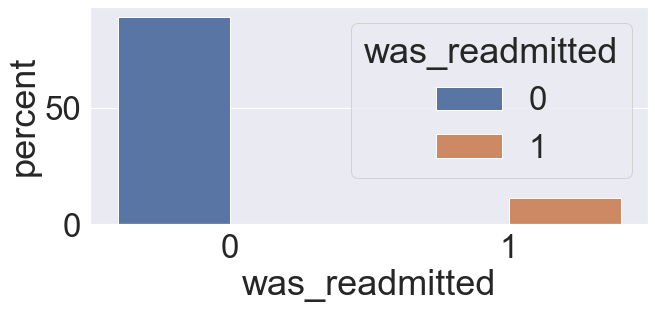

In [149]:
plt.figure(figsize=(10,4))
sns.barplot(x="was_readmitted", y="percent", hue="was_readmitted", data=df_gb)
plt.show()

### Check value counts for mapped values

In [150]:
print(df['admission_source_id'].value_counts())

 Emergency Room                                               57494
 Physician Referral                                           29565
Transfer from a hospital                                       3187
 Transfer from another health care facility                    2264
Clinic Referral                                                1104
 Transfer from a Skilled Nursing Facility (SNF)                 855
HMO Referral                                                    187
 Not Mapped                                                     161
 Not Available                                                  125
 Court/Law Enforcement                                           16
 Transfer from hospital inpt/same fac reslt in a sep claim       12
 Transfer from critial access hospital                            8
 Transfer from Ambulatory Surgery Center                          2
Normal Delivery                                                   2
 Extramural Birth                               

In [151]:
print(df['admission_type_id'].value_counts())

Urgent           53990
Newborn          18869
Elective         18480
Trauma Center     5291
Not Mapped          21
Not Available       10
Name: admission_type_id, dtype: int64


In [152]:
print(df['discharge_disposition_id'].value_counts())

Discharged/transferred to another short term hospital                                                        60234
Discharged/transferred to ICF                                                                                13954
Left AMA                                                                                                     12902
Expired at home. Medicaid only, hospice.                                                                      3691
Discharged/transferred to SNF                                                                                 2128
Discharged/transferred to a long term care hospital.                                                          1993
Still patient or expected to return for outpatient services                                                   1642
Discharged/transferred to home with home health service                                                       1184
Unknown/Invalid                                                                 

### Handling NA values
Some of the mapped values included Not mapped and Not Available, so those values were replaced with NAN. <br>
Then the % of missing values for each feature was calc'd to evaluate the impact.

<AxesSubplot:>

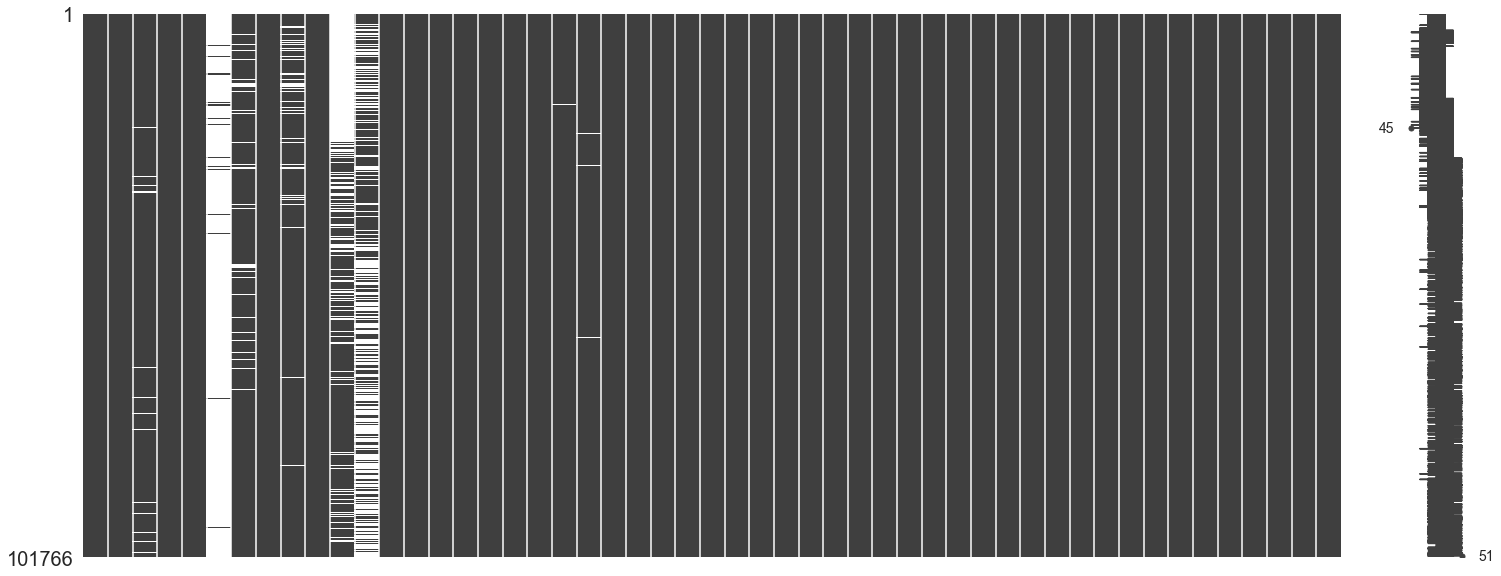

In [153]:
msno.matrix(df)

In [154]:
# Replace '?' with Nan
df = df.replace([' Not Mapped', ' Not Available', 'Not Mapped', 'Not Available'], np.NAN)

# Count missing values
df_na = pd.DataFrame(df.isna().sum())
df_na.rename(columns={df_na.columns[0]: 'count'}, inplace = True)

df_na = df_na[df_na['count'] != 0]
df_na['percent_missing'] = df_na['count']/df.shape[0]
df_na = df_na.sort_values('count', ascending=False)

df_na

,count,percent_missing
weight,98569,0.968585
medical_specialty,49949,0.490822
payer_code,40256,0.395574
admission_source_id,7067,0.069444
admission_type_id,5136,0.050469
race,2273,0.022336
diag_3,1423,0.013983
diag_2,358,0.003518
discharge_disposition_id,62,0.000609
diag_1,21,0.000206


Seven variables have missing values as shown in the table above.
- **weight** has 98,569 missing values, which equal to about 97% missing.
- **medical_specialty** has about 49% missing values.
- **payer_code** has about 40% missing value.
- **race** and **diag_3** have alittle above 2% and 1% missing values, respectively.
- **diag_2** and **diag_1** have less than 1% missing values. 

Run Pearson Correlations to see if other columns have stronf correlation with these 7 variables and can be helpful to fill in missing values.

In [155]:
df_corr = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
df_corr = df_corr[['weight', 'medical_specialty', 'payer_code', 'race', 'diag_3', 'diag_2', 'diag_1']]
df_corr = df_corr.abs()
df_corr.style.background_gradient(cmap='Blues')

,weight,medical_specialty,payer_code,race,diag_3,diag_2,diag_1
encounter_id,0.009245,0.013884,0.369888,0.028370,0.068818,0.109559,0.040695
patient_nbr,0.003434,0.018978,0.364582,0.026747,0.070654,0.111112,0.049278
race,0.054619,0.002744,0.012574,1.000000,0.003335,0.004511,0.017456
gender,0.010623,0.014953,0.034695,0.033583,0.016728,0.008582,0.015656
age,0.007005,0.046885,0.180412,0.140272,0.058892,0.062124,0.059949
weight,1.000000,0.038246,0.032643,0.054619,0.020492,0.033069,0.002529
admission_type_id,0.008930,0.261957,0.114486,0.028540,0.000970,0.034589,0.000613
discharge_disposition_id,0.027608,0.024775,0.094038,0.000609,0.006209,0.001901,0.013566
admission_source_id,0.002069,0.073273,0.036246,0.018128,0.011235,0.000629,0.031139
time_in_hospital,0.019221,0.003048,0.058149,0.005376,0.017085,0.023193,0.005379


#### **weight**
From the correlation table above, **weight** does not seem to have strong correlation with any other columns.  With 97% missing values, it was dropped from the dataset due to unreliability.

#### **medical_specialty**
**medical_specialty** has the strongest correlation with admission_type_id. <br>
The correlation between each value of **medical_specialty** with admission_type_is was evealuated to see if admission_type_id can be helpful for missing value imputating for the column.

<AxesSubplot:>

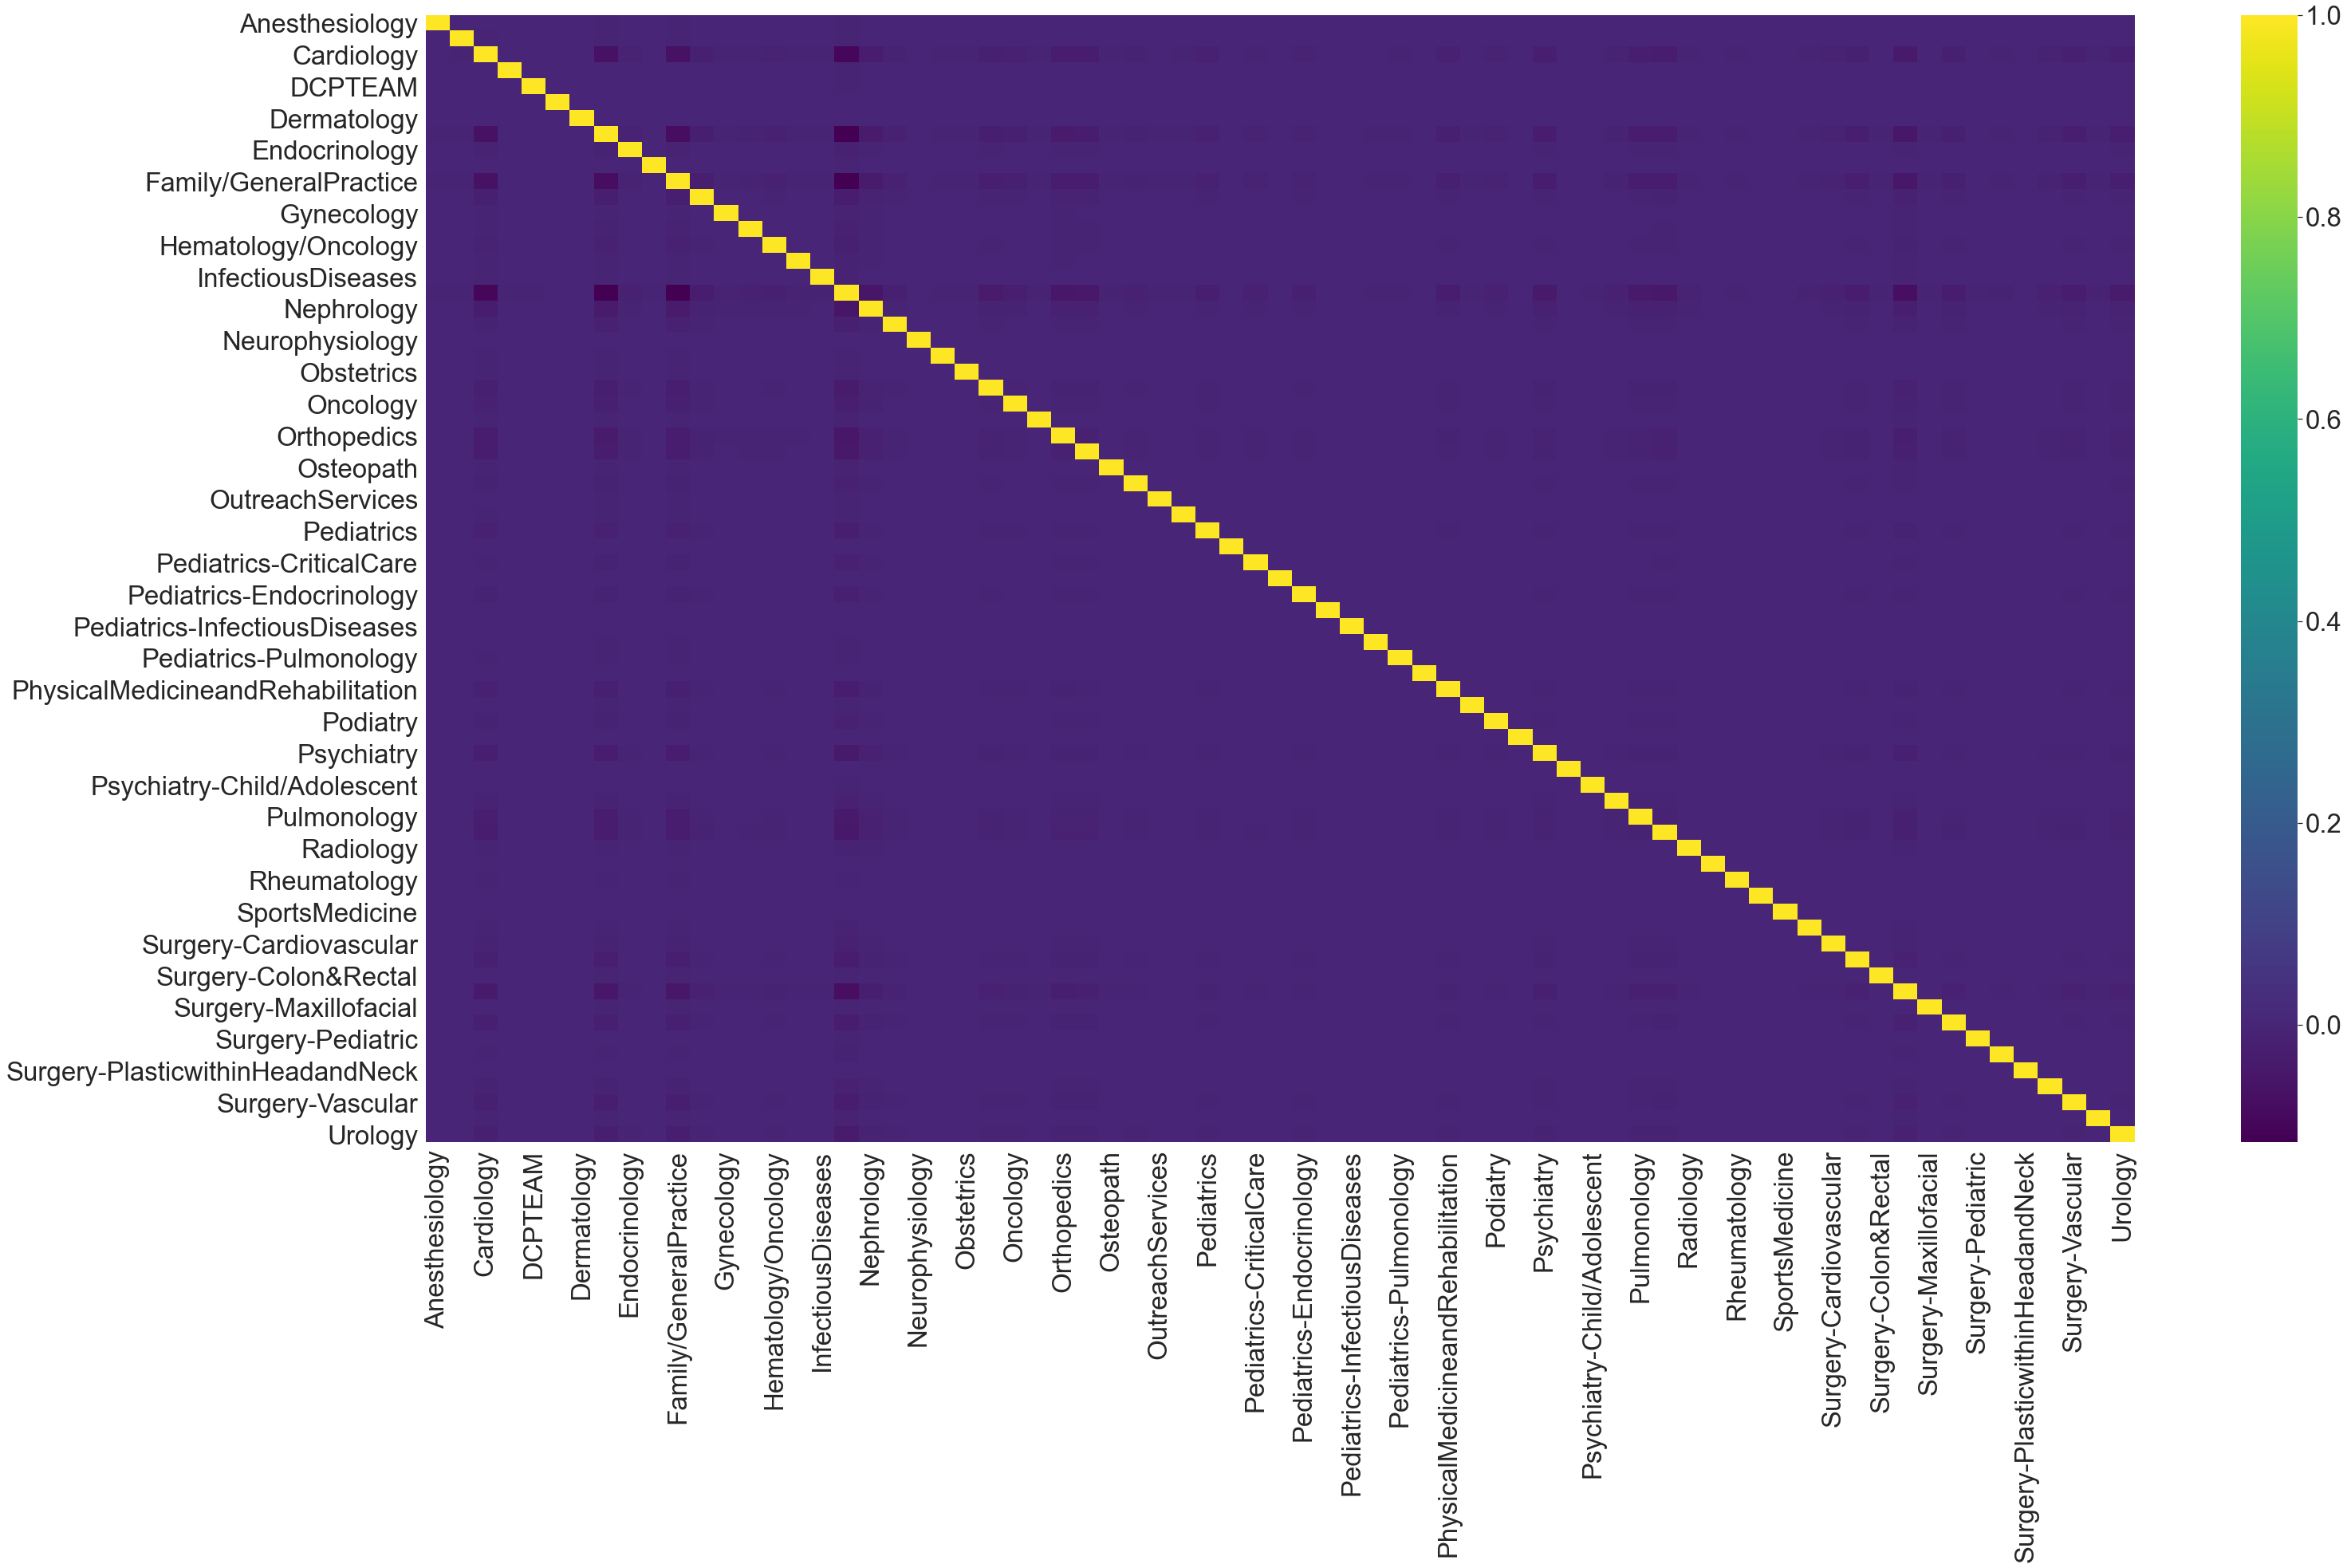

In [156]:
med_spec = df[['medical_specialty', 'admission_type_id']]

# using pd get dummies for the category columns we are keeping
dummies = pd.get_dummies(med_spec['medical_specialty'],drop_first=True)

#dropping original columns
med_spec_df = med_spec.drop('medical_specialty',axis=1)

#concating dummies to the data frame
med_spec_df = pd.concat([med_spec_df, dummies],axis=1)

plt.figure(figsize=(48,26))
sns.heatmap(med_spec_df.corr(), annot=False, cmap='viridis')

With all 73 different values (including missing value) within **medical_specialty**, there is no stong correlation with admission_type_id.<br>
The **medical_specialty** feature was filled with 'NA' to preserve the existing values.

#### **payer_code**


In [157]:
print(df['payer_code'].value_counts())

MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64


Without considering encounter_id and patient_nbr, which are unique identifiers for each patient, **payer_code** has the strongest correlation at 0.180 with age. <br>
The correlation between each value of **payer_code** with age was assessed to see if age can be helpful for missing value imputating for the column.

<AxesSubplot:xlabel='age', ylabel='payer_code'>

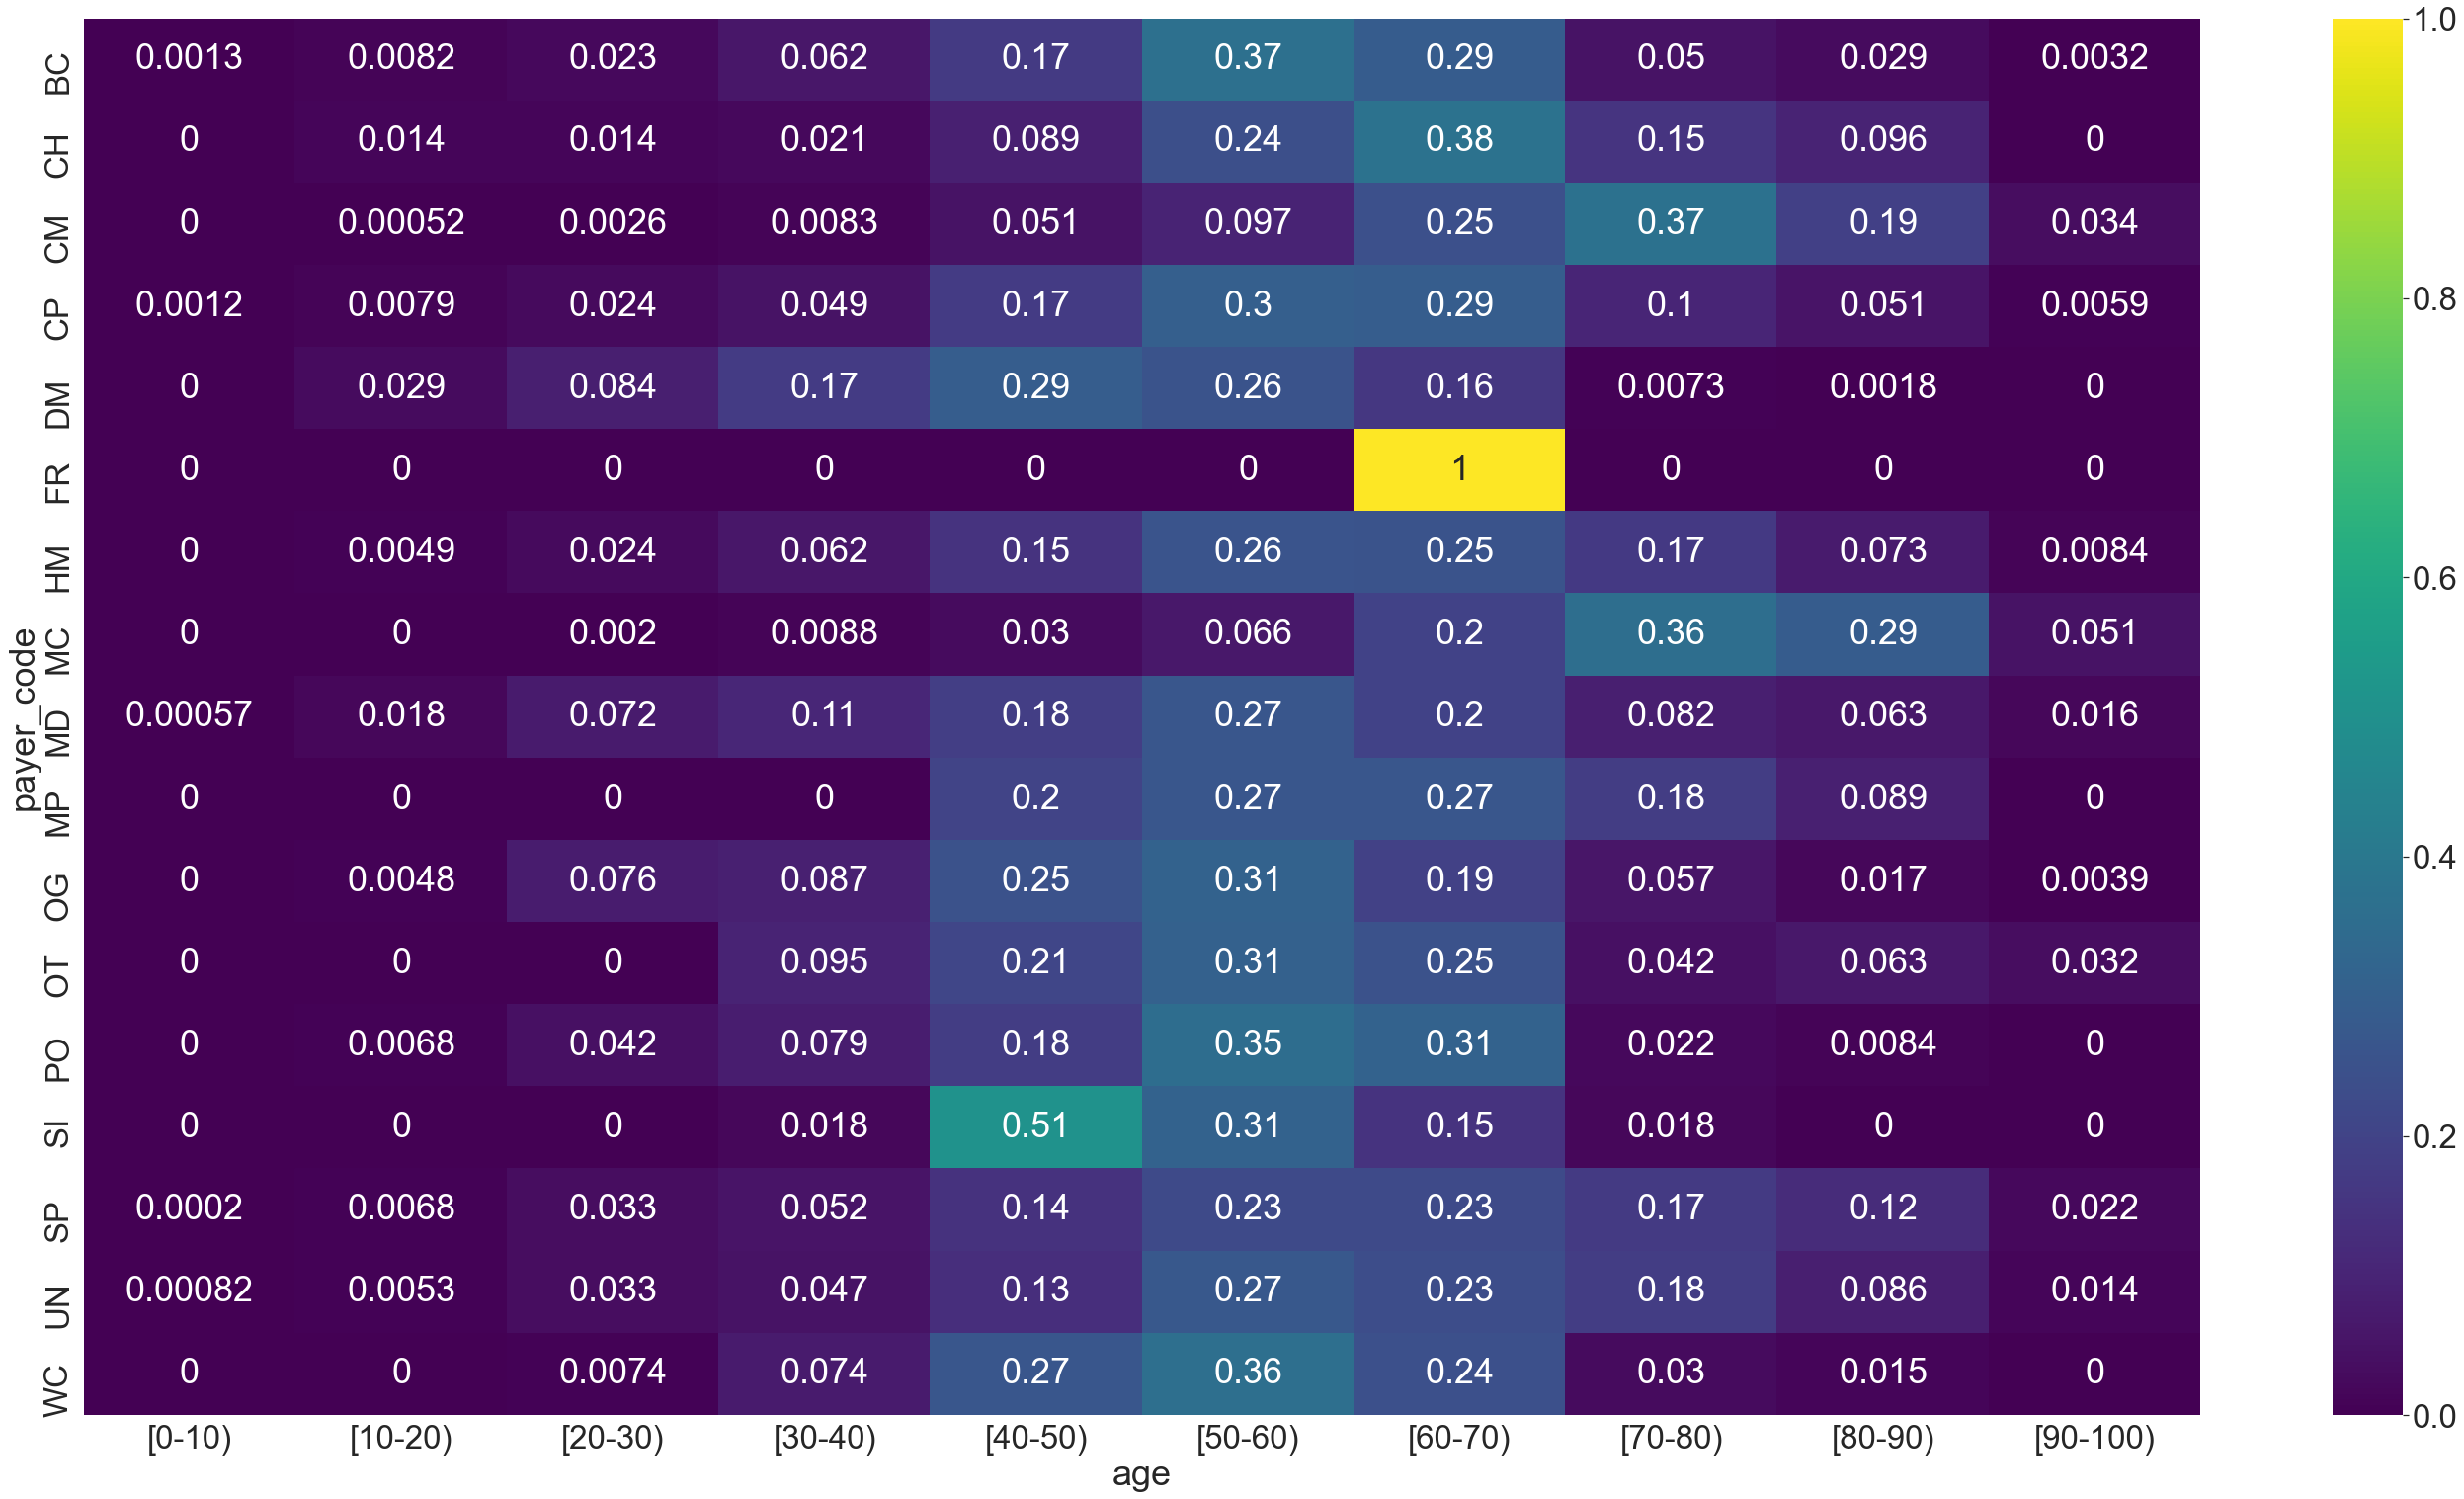

In [158]:
payer_code_vs_age = pd.DataFrame(pd.crosstab(df['payer_code'], df['age'], normalize='index'))

plt.figure(figsize=(48,26))
sns.set(font_scale=3)
sns.heatmap(payer_code_vs_age,annot=True,cmap='viridis')

#### **diag_1, diag_1, and diag_3**

**diag_1, diag_1, and diag_3** are correlated with each other at about *only* 0.09 - 0.11 and do not have strong correlation with any other variables in the dataset.

**diag_1, diag_1, and diag_3** were filled with 'NA' to preserve the existing values.

### Impute data

In [159]:
df_impute = df

# drop weight
df_impute.drop(columns=['weight'], axis=1, inplace=True)

# fill NA - medical_specialty, payer_code, race, 
df_impute.medical_specialty = df_impute.medical_specialty.fillna('NA')
df_impute.payer_code = df_impute.payer_code.fillna('NA')
df_impute.admission_source_id = df_impute.admission_source_id.fillna('NA')
df_impute.admission_type_id = df_impute.admission_type_id.fillna('NA')
df_impute.race = df_impute.race.fillna('NA')
df_impute.discharge_disposition_id = df_impute.discharge_disposition_id.fillna('Unknown/Invalid')
df_impute.diag_1 = df_impute.diag_1.fillna('NA')
df_impute.diag_2 = df_impute.diag_2.fillna('NA')
df_impute.diag_3 = df_impute.diag_3.fillna('NA')


In [160]:
df_impute.head(5)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,was_readmitted
0,2278392,8222157,Caucasian,Female,[0-10),Trauma Center,Unknown/Invalid,Physician Referral,1,NA,...,No,No,No,No,No,No,No,No,NO,0
1,149190,55629189,Caucasian,Female,[10-20),Urgent,Discharged/transferred to another short term h...,Emergency Room,3,NA,...,Up,No,No,No,No,No,Ch,Yes,>30,0
2,64410,86047875,AfricanAmerican,Female,[20-30),Urgent,Discharged/transferred to another short term h...,Emergency Room,2,NA,...,No,No,No,No,No,No,No,Yes,NO,0
3,500364,82442376,Caucasian,Male,[30-40),Urgent,Discharged/transferred to another short term h...,Emergency Room,2,NA,...,Up,No,No,No,No,No,Ch,Yes,NO,0
4,16680,42519267,Caucasian,Male,[40-50),Urgent,Discharged/transferred to another short term h...,Emergency Room,1,NA,...,Steady,No,No,No,No,No,Ch,Yes,NO,0


### Model Preperations

#### Target Variable - **readmitted**

Objective:
<li>Predict if a patient will re-admit at the hospital within 30 days of the initial admitted.</li>
<br>


There are 3 unique values in the **readmitted** target variable as shown below...
<li>values with 'less30' in the "readmitted" column were given the value 1 in the "was_readmitted" column
<li>any other values in the "readmitted" column were given the value of 0 in the "was_readmitted" column

In [161]:
df_model = df_impute

print(df_model["readmitted"].value_counts())
print(df_model["was_readmitted"].value_counts())


NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64
0    90409
1    11357
Name: was_readmitted, dtype: int64


### Categorical Variables

Reassesing categorical variables to see if some variables needed to be adjust before applying one-hot-coding.

In [162]:
df_object = df_model.select_dtypes(include=['object_'])
df_object.describe().transpose()

,count,unique,top,freq
race,101766,6,Caucasian,76099
gender,101766,3,Female,54708
age,101766,10,[70-80),26068
admission_type_id,101766,5,Urgent,53990
discharge_disposition_id,101766,24,Discharged/transferred to another short term h...,60234
admission_source_id,101766,15,Emergency Room,57494
payer_code,101766,18,NA,40256
medical_specialty,101766,73,NA,49949
diag_1,101766,717,428,6862
diag_2,101766,749,276,6752


### medical_specialty top 35 values

<AxesSubplot:title={'center':'medical_specialty top 35 values'}, xlabel='medical_specialty', ylabel='percent'>

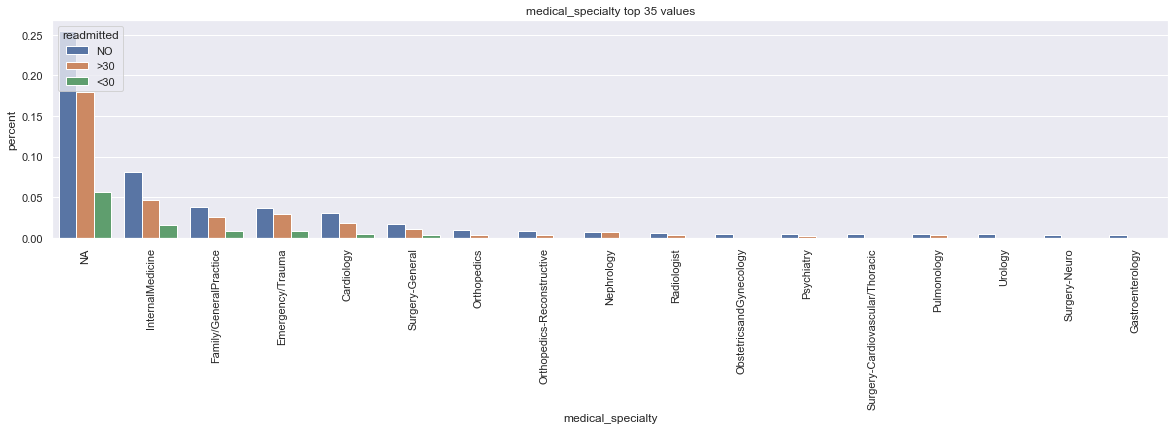

In [163]:
cat_value = "medical_specialty"

df_gb = df_model.groupby(["readmitted", cat_value])["encounter_id"].count().reset_index(name="var_count")
df_gb["percent"] = df_gb["var_count"]/df_gb.var_count.sum()

plt.figure(figsize=(20,4))
sns.set(font_scale=1)
plt.xticks(rotation=90)
plt.title(cat_value + " top 35 values")
sns.barplot(x=cat_value, y="percent", data=df_gb.nlargest(35, "percent"), hue='readmitted')

### diag_1 top 35 values

<AxesSubplot:title={'center':'diag_1 top 35 values'}, xlabel='diag_1', ylabel='percent'>

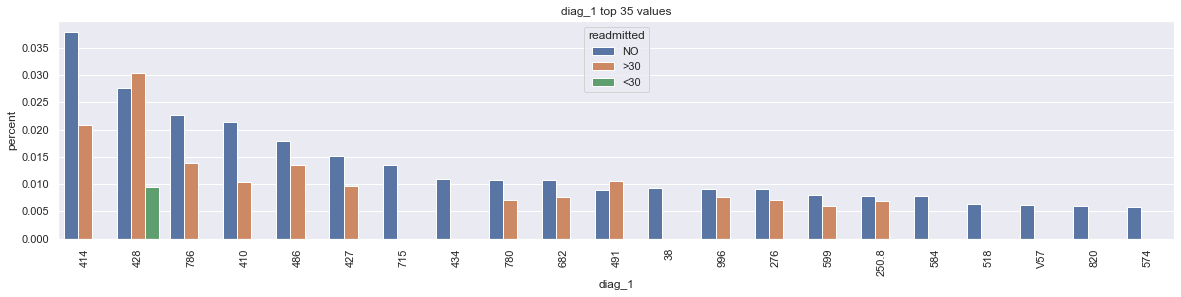

In [164]:
cat_value = "diag_1"

df_gb = df_model.groupby(["readmitted", cat_value])["encounter_id"].count().reset_index(name="var_count")
df_gb["percent"] = df_gb["var_count"]/df_gb.var_count.sum()

plt.figure(figsize=(20,4))
sns.set(font_scale=1)
plt.xticks(rotation=90)
plt.title(cat_value + " top 35 values")
sns.barplot(x=cat_value, y="percent", data=df_gb.nlargest(35, "percent"), hue='readmitted')

### diag_2 top 35 values

<AxesSubplot:title={'center':'diag_2 top 35 values'}, xlabel='diag_2', ylabel='percent'>

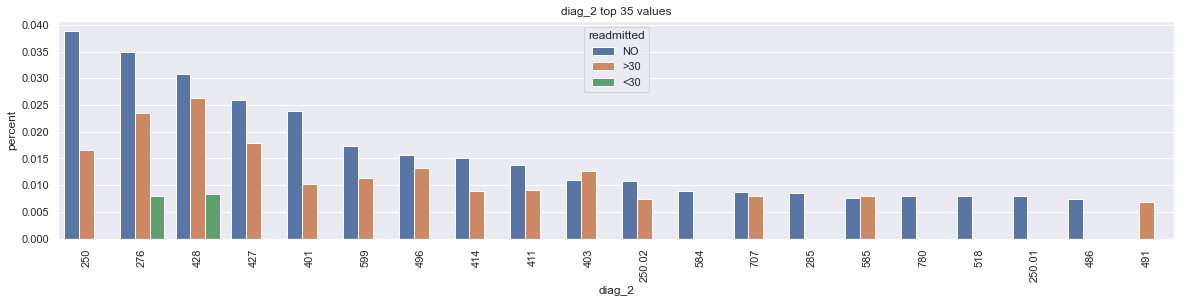

In [165]:
cat_value = "diag_2"

df_gb = df_model.groupby(["readmitted", cat_value])["encounter_id"].count().reset_index(name="var_count")
df_gb["percent"] = df_gb["var_count"]/df_gb.var_count.sum()

plt.figure(figsize=(20,4))
sns.set(font_scale=1)
plt.xticks(rotation=90)
plt.title(cat_value + " top 35 values")
sns.barplot(x=cat_value, y="percent", data=df_gb.nlargest(35, "percent"), hue='readmitted')

### diag_3 top 35 values

<AxesSubplot:title={'center':'diag_3 top 35 values'}, xlabel='diag_3', ylabel='percent'>

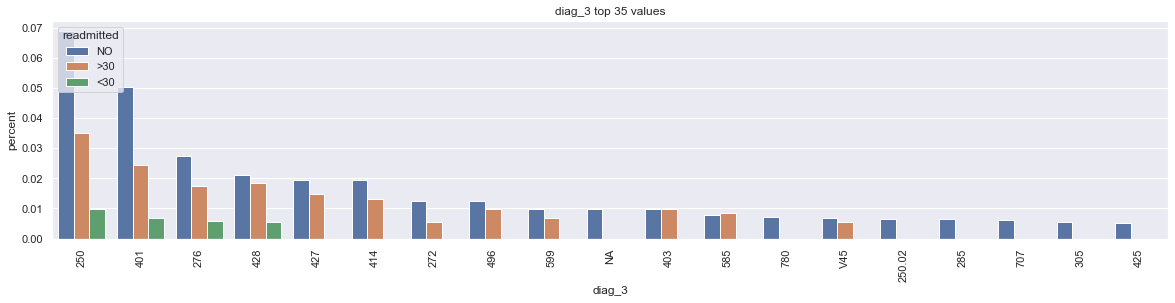

In [166]:
cat_value = "diag_3"

df_gb = df_model.groupby(["readmitted", cat_value])["encounter_id"].count().reset_index(name="var_count")
df_gb["percent"] = df_gb["var_count"]/df_gb.var_count.sum()

plt.figure(figsize=(20,4))
sns.set(font_scale=1)
plt.xticks(rotation=90)
plt.title(cat_value + " top 35 values")
sns.barplot(x=cat_value, y="percent", data=df_gb.nlargest(35, "percent"), hue='readmitted')


**medical_specialty, diag_1, diag_1, and diag_3** has 73, 717, 749, and 790 unique values, respectively. To reduce the complication of one-hot-coding, we groupped the values in each column that appear <1% of the dataset (1,018 records) as 'Others'.

In [167]:
def major(cols):
    x = df_model.groupby(by=cols, as_index=False).agg({'encounter_id': pd.Series.nunique})
    x.rename(columns={x.columns[0]: 'val', x.columns[1]: 'count'}, inplace = True)
    x['percent_appears'] = x['count']/df_model.shape[0]
    x = x[x['percent_appears'] > .01]
    row_to_list = x['val'].to_list()
    return row_to_list

medical_specialty_major = major(df_model['medical_specialty'])
df_model['medical_specialty_reduced'] = np.where(~df_model['medical_specialty'].isin(medical_specialty_major), "Others", df_model['medical_specialty'])
df_model.drop(columns=['medical_specialty'], axis=1, inplace=True)

diag1_major = major(df_model['diag_1'])
df_model['diag_1_reduced'] = np.where(~df_model['diag_1'].isin(diag1_major), "Others", df_model['diag_1'])
df_model.drop(columns=['diag_1'], axis=1, inplace=True)

diag2_major = major(df_model['diag_2'])
df_model['diag_2_reduced'] = np.where(~df_model['diag_2'].isin(diag2_major), "Others", df_model['diag_2'])
df_model.drop(columns=['diag_2'], axis=1, inplace=True)

diag3_major = major(df_model['diag_3'])
df_model['diag_3_reduced'] = np.where(~df_model['diag_3'].isin(diag3_major), "Others", df_model['diag_3'])
df_model.drop(columns=['diag_3'], axis=1, inplace=True)

Since **examide** and **citoglipton** columns only had one unique value, they won't be useful for the model so the columns were dropped. <br>

In [168]:
df_model.drop(columns=['examide', 'citoglipton'], axis=1, inplace=True)

Dropped **encounter_id** and **patient_nbr** because id number's are not need for the model. <br>
Dropped the **readmitted** column, because it target column was derived from it.

In [169]:
df_model.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'], axis=1, inplace=True)

In [170]:
df_model.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,was_readmitted,medical_specialty_reduced,diag_1_reduced,diag_2_reduced,diag_3_reduced
0,Caucasian,Female,[0-10),Trauma Center,Unknown/Invalid,Physician Referral,1,NA,41,0,...,No,No,No,No,No,0,Others,Others,Others,NA
1,Caucasian,Female,[10-20),Urgent,Discharged/transferred to another short term h...,Emergency Room,3,NA,59,0,...,No,No,No,Ch,Yes,0,NA,276,250.01,Others
2,AfricanAmerican,Female,[20-30),Urgent,Discharged/transferred to another short term h...,Emergency Room,2,NA,11,5,...,No,No,No,No,Yes,0,NA,Others,250,Others
3,Caucasian,Male,[30-40),Urgent,Discharged/transferred to another short term h...,Emergency Room,2,NA,44,1,...,No,No,No,Ch,Yes,0,NA,Others,Others,403
4,Caucasian,Male,[40-50),Urgent,Discharged/transferred to another short term h...,Emergency Room,1,NA,51,0,...,No,No,No,Ch,Yes,0,NA,Others,Others,250


## One-hot Encode
One-hot encode categorical variables then drop originals.

In [171]:
df_object = df_model.select_dtypes(include=['object_'])

Categoricals_to_convert = list(df_object)

# using pd get dummies for the category columns we are keeping
dummies = pd.get_dummies(df_model[Categoricals_to_convert],drop_first=True)

#dropping original columns
df_model = df_model.drop(Categoricals_to_convert,axis=1)

#concating dummies to the data frame
df_model = pd.concat([df_model,dummies],axis=1)

df_model.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,was_readmitted,race_Asian,...,diag_3_reduced_427,diag_3_reduced_428,diag_3_reduced_496,diag_3_reduced_585,diag_3_reduced_599,diag_3_reduced_707,diag_3_reduced_780,diag_3_reduced_NA,diag_3_reduced_Others,diag_3_reduced_V45
0,1,41,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,59,0,18,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,11,5,13,2,0,1,6,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2,44,1,16,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,51,0,8,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model

### Imports

In [172]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


### Create 10% holdout set

In [173]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_valid_index in split.split(df_model, df_model.was_readmitted):
    modeling_data = df_model.iloc[train_index]
    validation_data = df_model.iloc[test_valid_index]

In [174]:
print("Size of modeling set (to be CV split): ", modeling_data.shape)
print("Size of hold back validation set: ", validation_data.shape)

Size of modeling set (to be CV split):  (91589, 216)
Size of hold back validation set:  (10177, 216)


In [175]:
# modeling_data.to_csv('df_modeling.csv', sep=',', encoding='utf-8')
# validation_data.to_csv('df_validation.csv', sep=',', encoding='utf-8')

### Setup modeling data

In [176]:
#Create new X predictor matrix
X_model = modeling_data.drop(['was_readmitted'],axis=1) #droping target
y_model = modeling_data['was_readmitted']
y_model = y_model.astype(int)

### Setup validation data

In [177]:
#Create new X predictor matrix
X_validate = validation_data.drop(['was_readmitted'],axis=1) #droping target
y_validate = validation_data['was_readmitted']
y_validate = y_validate.astype(int)

### Create scalar object

Using "ColumnTransform" to scale only the continous variabels using the standard scalar

In [178]:
#Scale new predictor matrix

con_vars = ['time_in_hospital', 'number_diagnoses',
    'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient',
]

scalar_obj = ColumnTransformer(transformers=[('StandardScaler', StandardScaler(), con_vars)],
                                          remainder='passthrough') # Default is to drop untransformed columns

### Define model

In [179]:
lr = LogisticRegression(penalty='elasticnet', C=10, l1_ratio=0.01, class_weight='balanced', solver='saga', max_iter=100, multi_class='auto', tol=.0001, random_state=42)

### Setup pipeline

Configuring the pipline to properly scale the data for cross validation, and run the data through the logistic regression model.

In [180]:
pipeline = Pipeline([
    ('scaler', scalar_obj),
    ('classifier', lr)
])

### Setup Scorer

In [181]:
scorer = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'), 
    'F1': make_scorer(f1_score, average='macro')
}

### CV using all variables...

5 fold cross validation was used to train the model, and the results from each fold were consistent not causing concern for overfitting <br>
So the entire traing set was used to train the model.

In [182]:
model_res = cross_validate(pipeline, X_model, y_model, cv=5, scoring=scorer, error_score="raise")


print("Precision(all models) = ",model_res['test_precision'])
print("Recall(all models) = ",model_res['test_recall'])
print("F1(all models) = ",model_res['test_F1'])

print("\n\n")

print("Mean Precision = ",model_res['test_precision'].mean())
print("Mean Recall = ",model_res['test_recall'].mean())
print("Mean F1 = ",model_res['test_F1'].mean())

c:\Users\OaklandHillsMansion\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\Users\OaklandHillsMansion\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\Users\OaklandHillsMansion\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\Users\OaklandHillsMansion\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Precision(all models) =  [0.55401529 0.55211692 0.55147979 0.55046022 0.55290184]
Recall(all models) =  [0.62323224 0.61906903 0.6180528  0.61567363 0.62234077]
F1(all models) =  [0.53045231 0.52772279 0.52610937 0.52480322 0.52601976]



Mean Precision =  0.5521948099300784
Mean Recall =  0.6196736930965602
Mean F1 =  0.5270214888334797


c:\Users\OaklandHillsMansion\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### Fit using all variables...

In [183]:
# Base model
base_model = lr.fit(X_model,y_model)
# print(base_model.score(X_validate,y_validate)) # Return accuracy

c:\Users\OaklandHillsMansion\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### Threshold 0.5

A threshold of 0.5 yieled a percision of 0.18, a recall of 0.57 and an F1 score of 0.28.<br>

In [184]:
THRESHOLD = 0.5
lr_model_predictions = np.where(base_model.predict_proba(X_model)[:,1] > THRESHOLD, 1, 0)

print(classification_report(y_model,lr_model_predictions))

              precision    recall  f1-score   support

           0       0.93      0.68      0.79     81368
           1       0.18      0.57      0.28     10221

    accuracy                           0.67     91589
   macro avg       0.56      0.63      0.53     91589
weighted avg       0.84      0.67      0.73     91589



### Treshold 0.45

A threshold of 0.45 yieled a percision of 0.16, a recall of 0.71 and an F1 score of 0.26.<br>
The recall vs precision tradeoff at 0.45 was preferred over 0.50 beacause it had a higher recall. 

In [185]:
THRESHOLD = 0.45
lr_model_predictions = np.where(base_model.predict_proba(X_model)[:,1] > THRESHOLD, 1, 0)

print(classification_report(y_model,lr_model_predictions))

              precision    recall  f1-score   support

           0       0.94      0.54      0.68     81368
           1       0.16      0.71      0.26     10221

    accuracy                           0.56     91589
   macro avg       0.55      0.62      0.47     91589
weighted avg       0.85      0.56      0.63     91589



### Use best model to predict validation dataset

Ran out of time trying to translate H20 models to the code base, so the base model was used as the best model

In [186]:
# Best model
best_model = base_model

### Function for confusion plot

In [187]:
def plot_confusion(cf_matrix):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=2)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
    cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n' for v1, v2 in
    zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    # x_axis_labels = ['<30', '>30']
    # y_axis_labels = ['<30', '>30']
    ax = plt.axes()
    # sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('   Hospital Readmission Confusion Matrix\n')
    plt.xlabel("Predicted Readmission")
    plt.ylabel("True Readmission") 


## Make predictions on hold back validation set to compare metrics to the CV model

After evaluating the thresholds on the training data, the threshold value of 0.45 was used to indicated if a patient is flagged for readmittance

In [188]:
lr_validation_predictions = np.where(best_model.predict_proba(X_validate)[:,1] > THRESHOLD, 1, 0)

print(classification_report(y_model,lr_model_predictions))

              precision    recall  f1-score   support

           0       0.94      0.54      0.68     81368
           1       0.16      0.71      0.26     10221

    accuracy                           0.56     91589
   macro avg       0.55      0.62      0.47     91589
weighted avg       0.85      0.56      0.63     91589



### Confusion Matrix

The model flagged 48% of the patients as at risk for readmittance

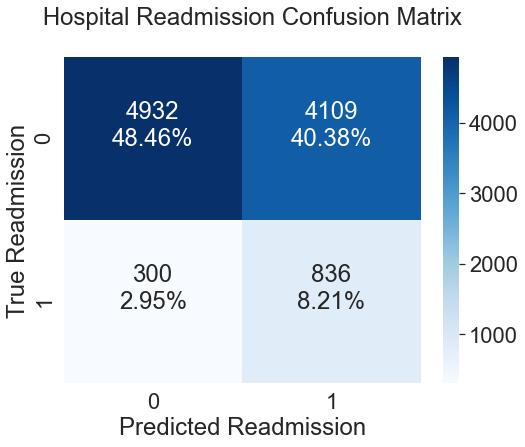

In [189]:
lr_cm = confusion_matrix(y_validate,lr_validation_predictions)
plot_confusion(lr_cm)

### AUC Curve

The AUC for the final models predictions on the hold out set was 0.64

0.6407151848153404


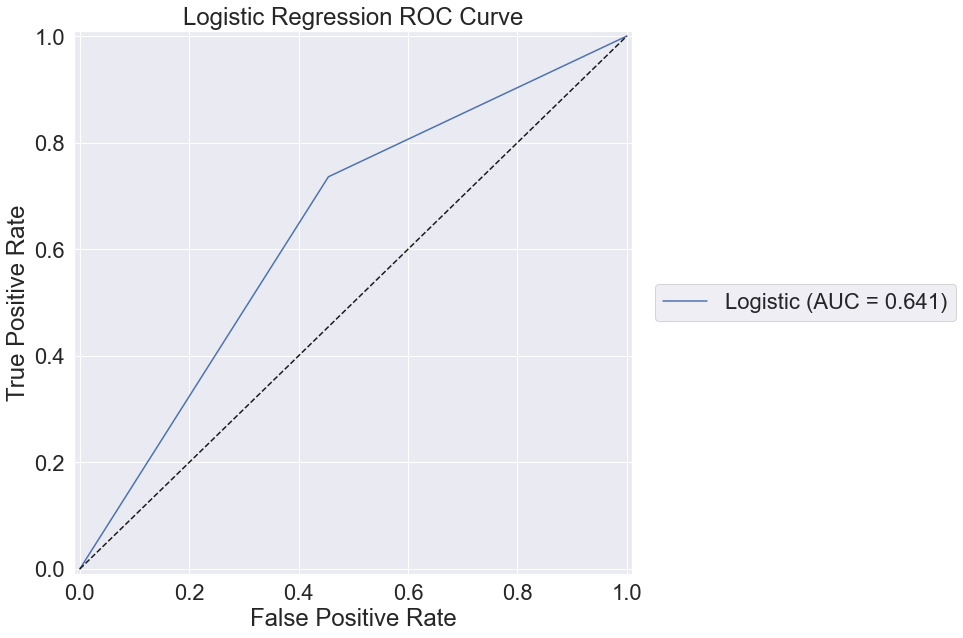

In [190]:
#Calculate probabilities on predictions (not just classifications) needed for AUC
lr_probabilities = best_model.predict_proba(X_validate)


lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_validate, lr_validation_predictions)
lr_auc = roc_auc_score(y_validate, lr_validation_predictions)

print(lr_auc)

# Plot ROC curve
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(lr_fpr, lr_tpr, label='Logistic (AUC = %0.3f)' % lr_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

### Logistic Regression Feature Importance 

Discharge accounted for all of the top 5 most important features for the model.

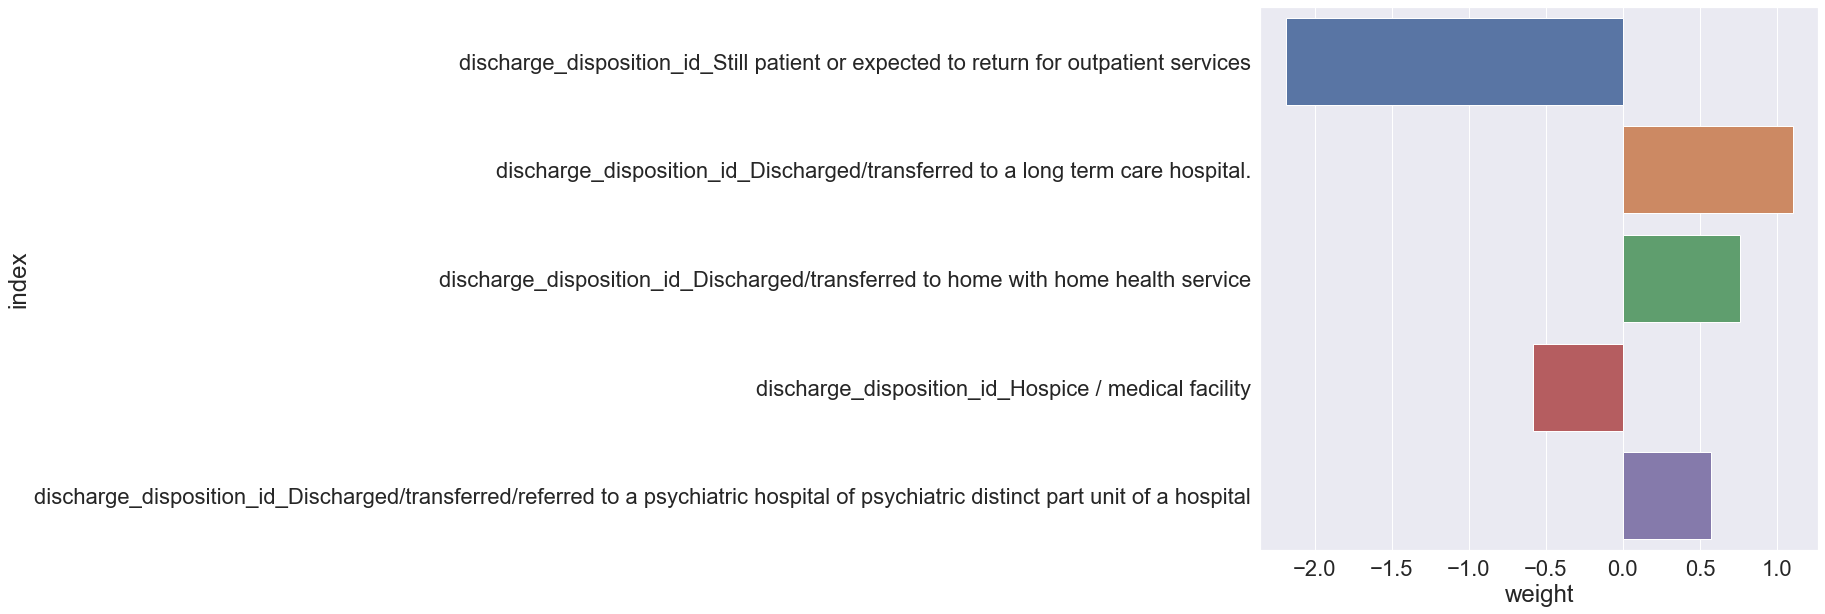

In [191]:
weights = best_model.coef_.T # take transpose to make a column vector
variable_names = X_validate.columns 

coefficients = pd.DataFrame(weights,variable_names)
coefficients = coefficients.rename(columns={coefficients.columns[0]: 'weight'})
coefficients = coefficients.sort_values(by='weight', key=abs, ascending=False)
coefficients.reset_index(level=0, inplace=True)

ax = sns.barplot(y="index", x="weight", data=coefficients.head(5))

### Coefficients

In [192]:
coefficients

,index,weight
0,discharge_disposition_id_Still patient or expe...,-2.187057
1,discharge_disposition_id_Discharged/transferre...,1.103824
2,discharge_disposition_id_Discharged/transferre...,0.760259
3,discharge_disposition_id_Hospice / medical fac...,-0.580768
4,discharge_disposition_id_Discharged/transferre...,0.571520
...,...,...
210,payer_code_UN,0.001991
211,admission_source_id_ Sick Baby,-0.001936
212,time_in_hospital,0.001371
213,num_lab_procedures,0.000280


### Conclusion

The F1 score was slightly lower, in relation to the F1 score for the threshold of 0.50, <br>
but the increase in recall was enough for us to go with the 0.45 model. <br> 
The higher recall was favored because we'd rather have to model flag someone for being at <br>
risk for readmittance who isn't as oppose to missing someone who is not. <br>
The reason for that is we think the potetnital loss of incorrectly flagging someone as <br>
risk for readmittance can be mitigated by embedding the model in buisness process <br>
where a medical professional or asscoiate would review the patients the model flagged as at risk <br>
and decide a course of action for the patient.